In [1]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import os
import skimage

import numpy as np
import pandas as pd

import skimage.measure
from skimage import morphology
from scipy.ndimage import gaussian_filter

from alpineer.io_utils import list_folders

from skimage.measure import label
from skimage import morphology
import utils
import natsort as ns

In [2]:
cell_table_clusters = pd.read_csv(os.path.join('data', 'invasive_cells.csv'))
cell_table_clusters = cell_table_clusters.loc[:, ['fov', 'segmentation_label', 'cell_type']]
cell_table_clusters.columns = ['fov', 'label', 'cell_type']

In [3]:
# paths
base_dir = r'/Volumes/Shared/Inna Averbukh/DCIS/Cohorts/20230317_DCIS'
channel_dir = os.path.join(base_dir, 'image_data')
seg_dir = os.path.join(base_dir, 'segmentation', 'deepcell_output')
mask_dir = os.path.join('data', 'mask_dir')

folders = np.unique(cell_table_clusters['fov'])

In [4]:
# create directories to hold masks
if not os.path.exists(mask_dir):
    os.mkdir(mask_dir)
    
intermediate_dir = os.path.join(mask_dir, 'intermediate_masks')
if not os.path.exists(intermediate_dir):
    os.mkdir(intermediate_dir)

individual_dir = os.path.join(mask_dir, 'individual_masks')
if not os.path.exists(individual_dir):
    os.mkdir(individual_dir)

In [5]:
cell_table_clusters

fov  label cell_type
0       TA507_R3C7      1     Other
1       TA507_R3C7      2     Other
2       TA507_R3C7      3     Other
3       TA507_R3C7      4     Other
4       TA507_R3C7      5     Other
...            ...    ...       ...
151452  TA586_R9C3   3585    Cancer
151453  TA586_R9C3   3586    Cancer
151454  TA586_R9C3   3587    Cancer
151455  TA586_R9C3   3588    Cancer
151456  TA586_R9C3   3589     Other

[151457 rows x 3 columns]

In [6]:
folders

array(['TA507_R3C7', 'TA507_R4C4', 'TA508_R4C4', 'TA585_R11C6',
       'TA585_R11C7', 'TA585_R12C7', 'TA585_R1C1', 'TA585_R1C5',
       'TA585_R2C4', 'TA585_R2C7', 'TA585_R3C1', 'TA585_R3C2',
       'TA585_R3C3', 'TA585_R3C6', 'TA585_R4C1', 'TA585_R4C3',
       'TA585_R4C4', 'TA585_R5C1', 'TA585_R5C4', 'TA585_R5C6',
       'TA585_R5C7', 'TA585_R6C1', 'TA585_R6C4', 'TA585_R6C5',
       'TA585_R6C6', 'TA585_R7C1', 'TA585_R7C2', 'TA585_R7C5',
       'TA585_R7C6', 'TA585_R7C7', 'TA585_R8C1', 'TA585_R8C2',
       'TA585_R8C3', 'TA585_R8C5', 'TA585_R9C1', 'TA585_R9C3',
       'TA585_R9C5', 'TA585_R9C7', 'TA586_R10C1', 'TA586_R10C3',
       'TA586_R11C1', 'TA586_R11C4', 'TA586_R1C2', 'TA586_R3C4',
       'TA586_R4C1', 'TA586_R4C4', 'TA586_R5C5', 'TA586_R6C1',
       'TA586_R6C2', 'TA586_R6C3', 'TA586_R7C3', 'TA586_R8C2',
       'TA586_R8C3', 'TA586_R8C4', 'TA586_R8C5', 'TA586_R9C2',
       'TA586_R9C3'], dtype=object)

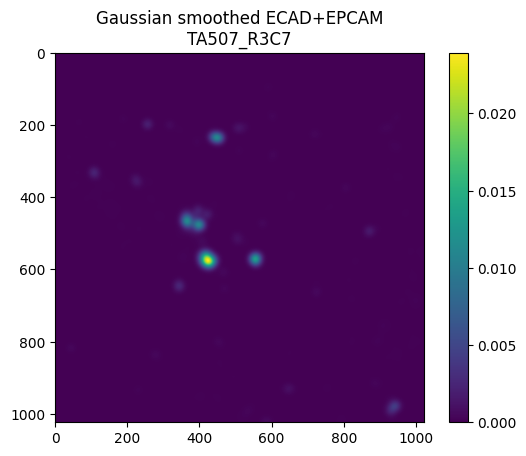

(1024, 1024)


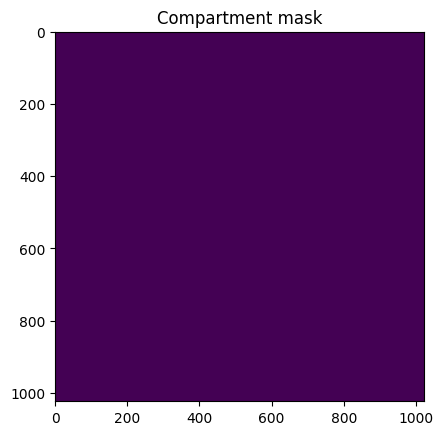

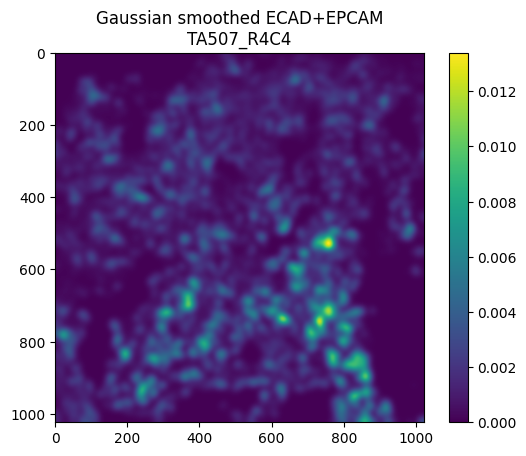

(1024, 1024)


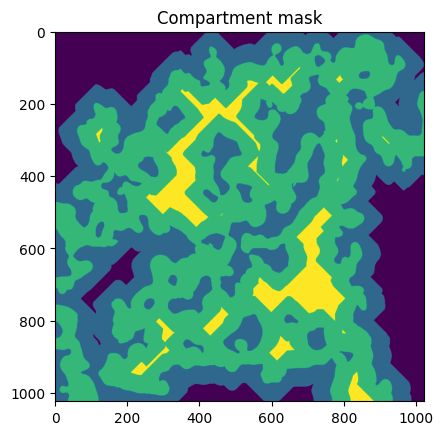

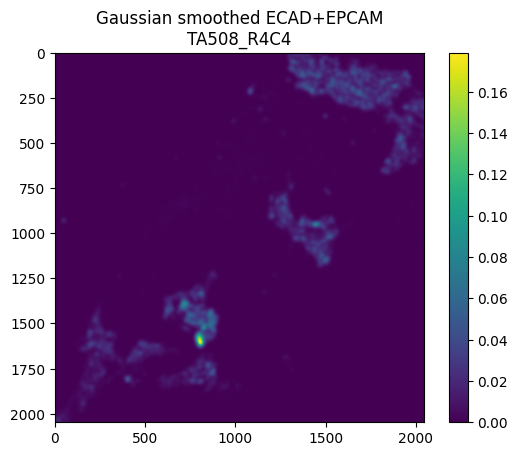

(2048, 2048)


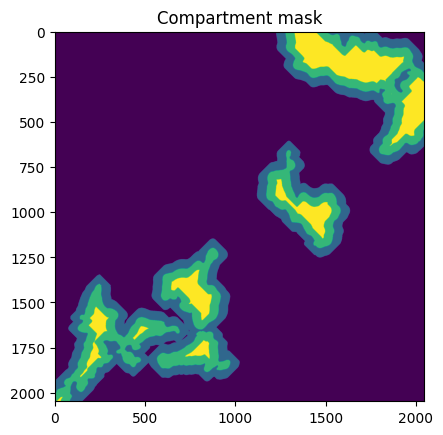

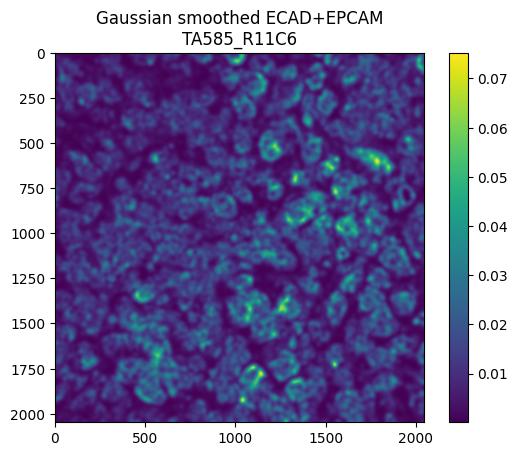

(2048, 2048)


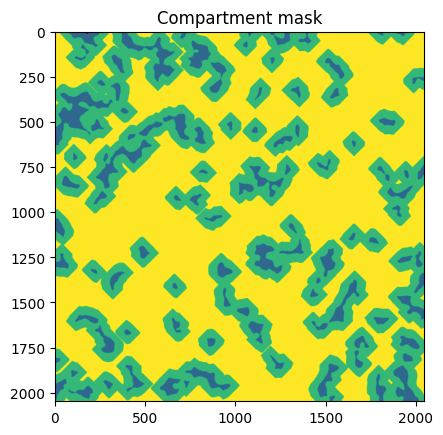

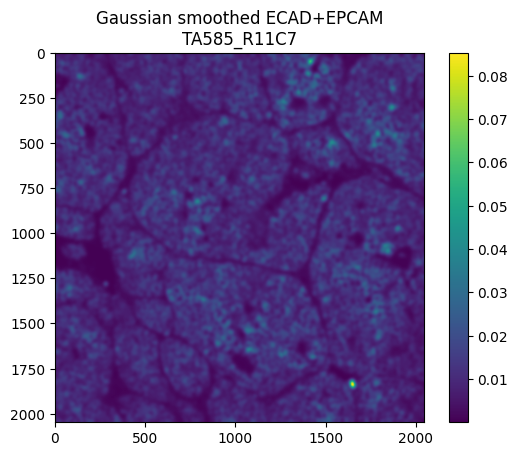

(2048, 2048)


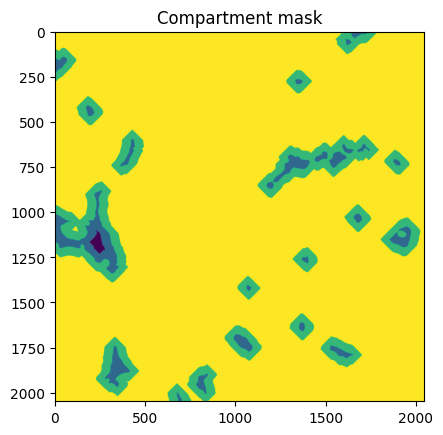

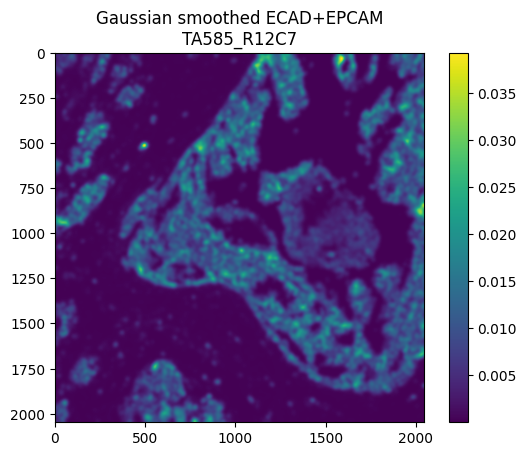

(2048, 2048)


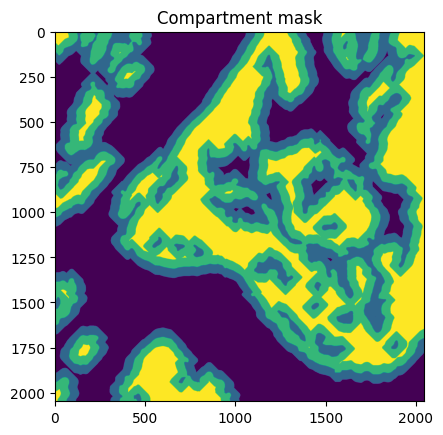

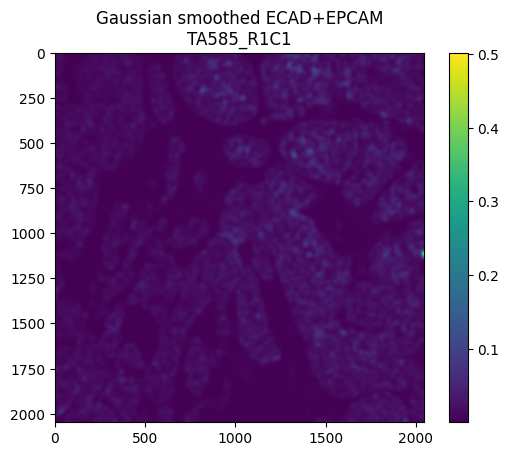

(2048, 2048)


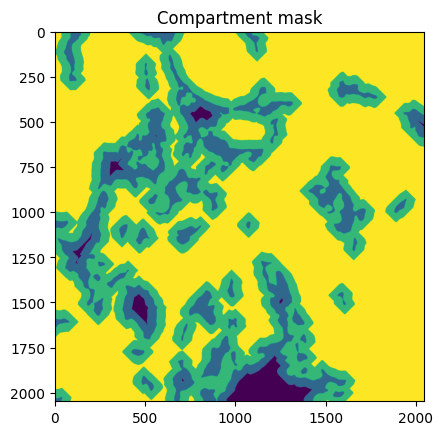

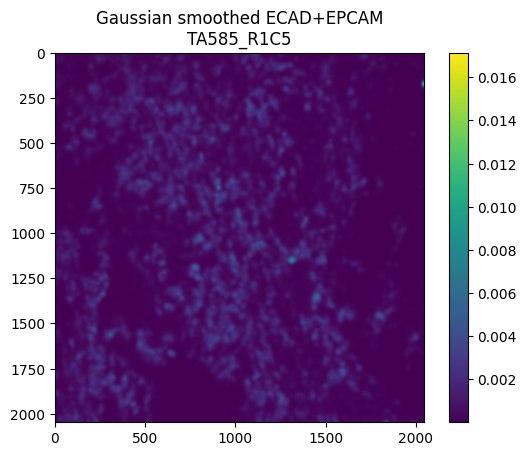

(2048, 2048)


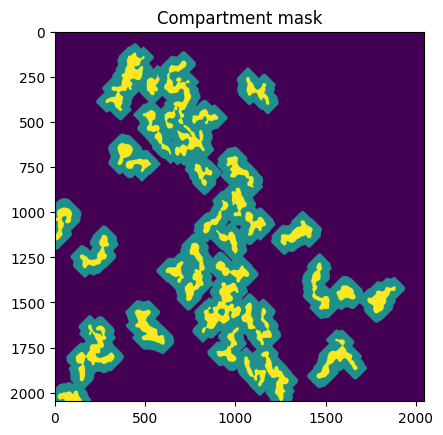

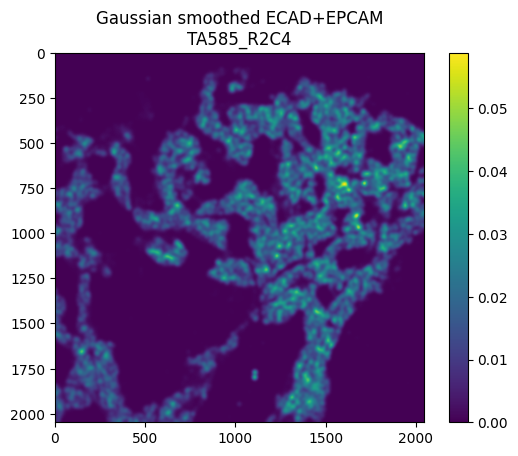

(2048, 2048)


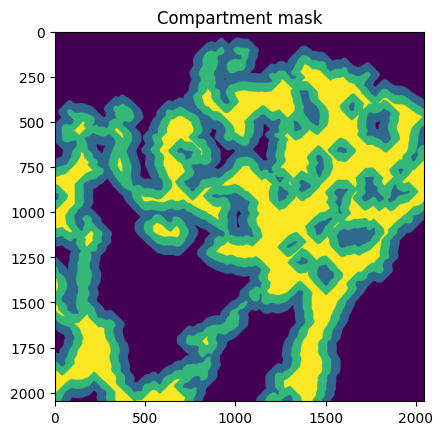

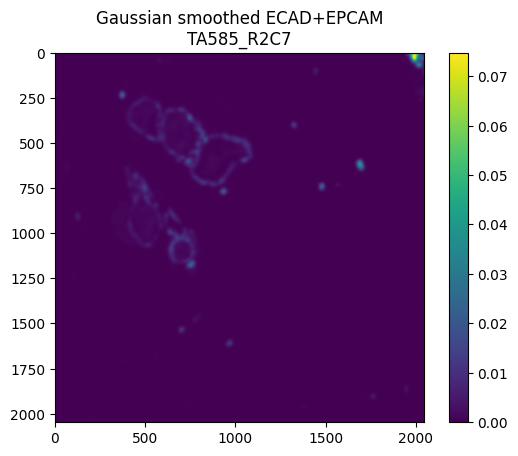

(2048, 2048)


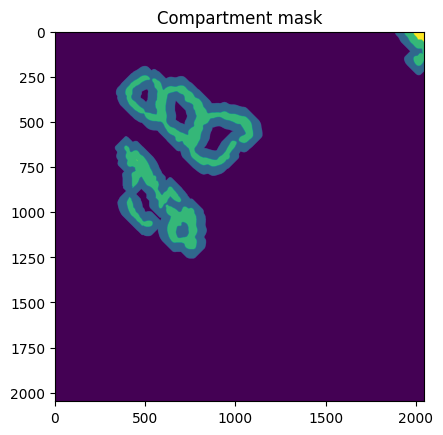

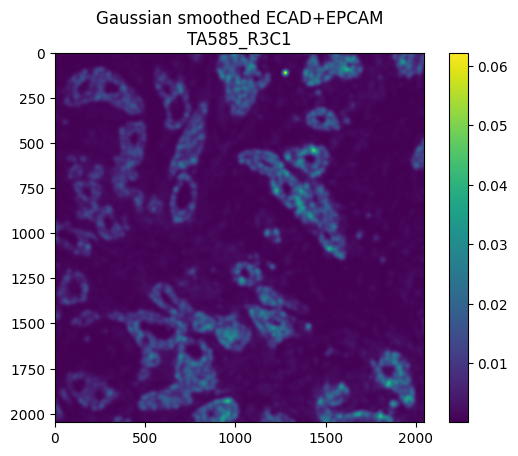

(2048, 2048)


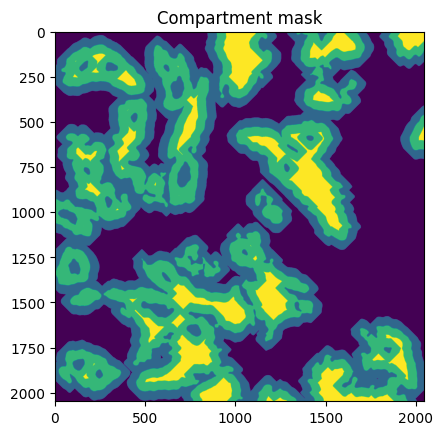

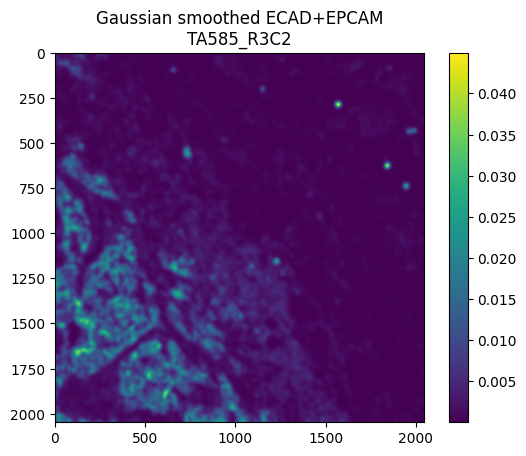

(2048, 2048)


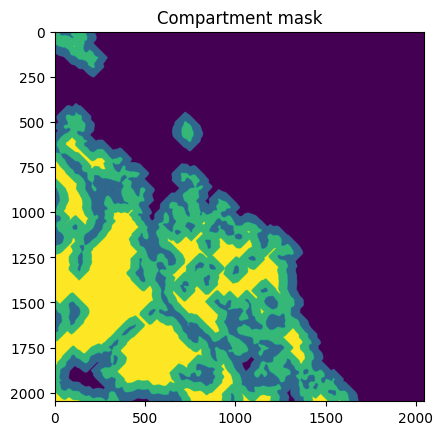

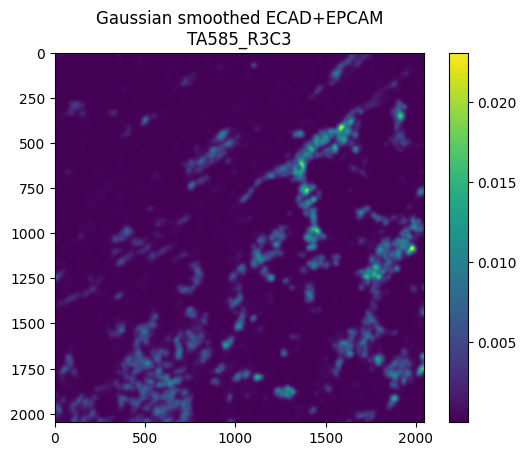

(2048, 2048)


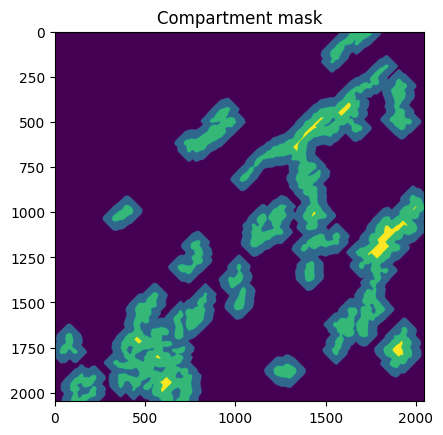

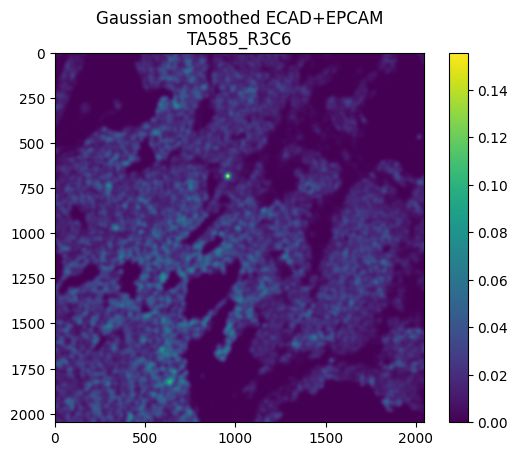

(2048, 2048)


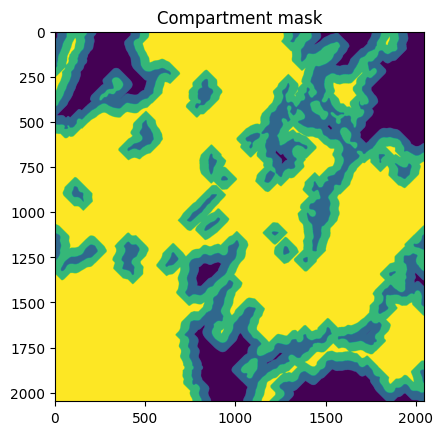

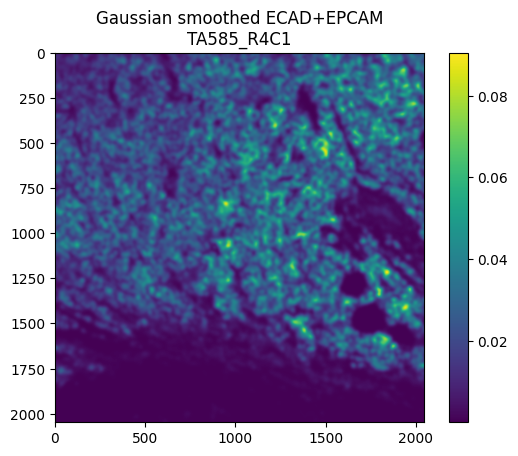

(2048, 2048)


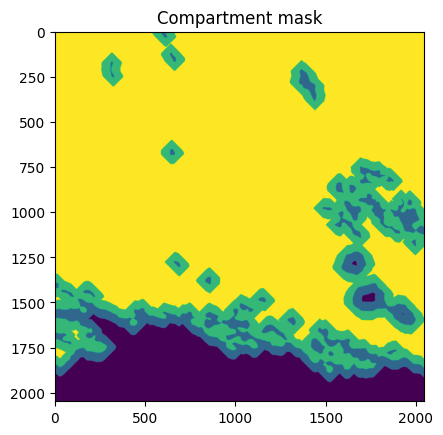

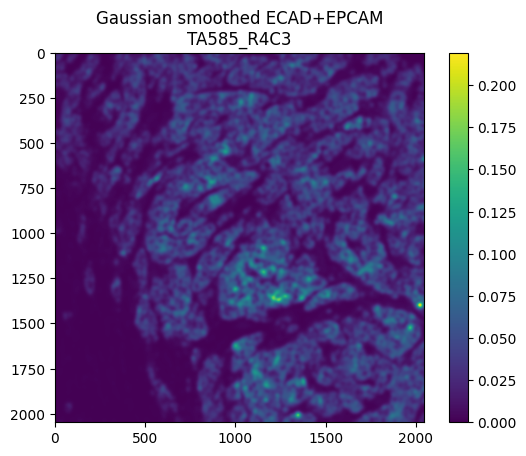

(2048, 2048)


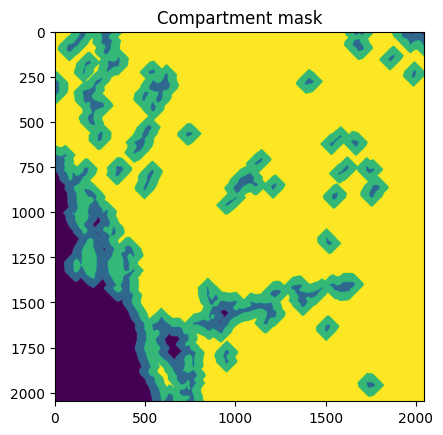

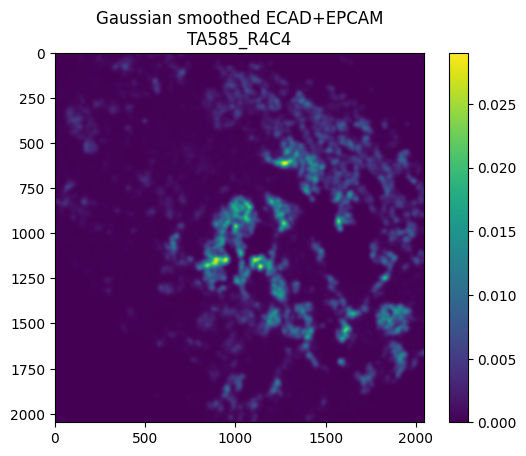

(2048, 2048)


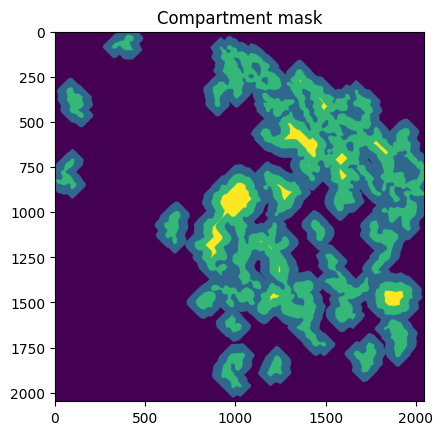

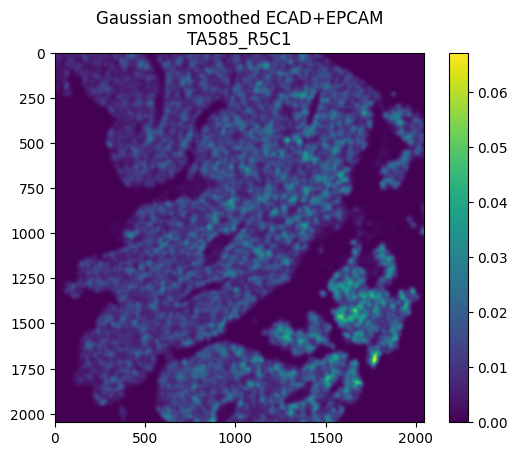

(2048, 2048)


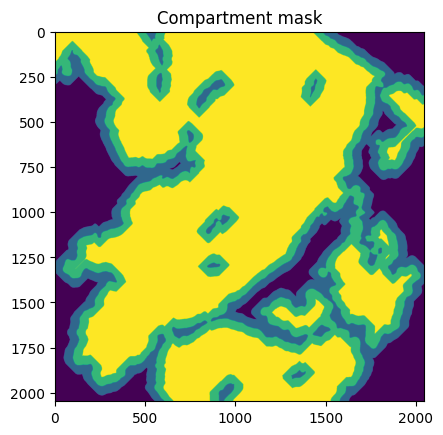

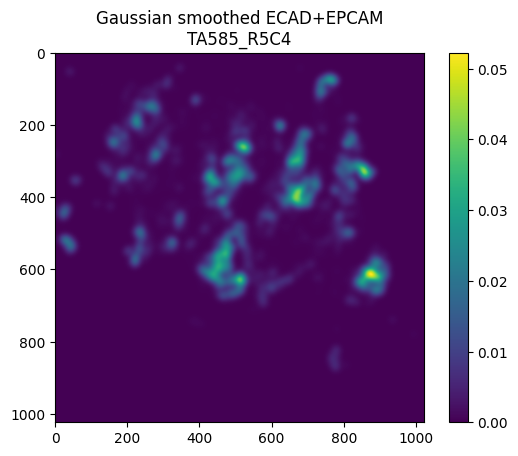

(1024, 1024)


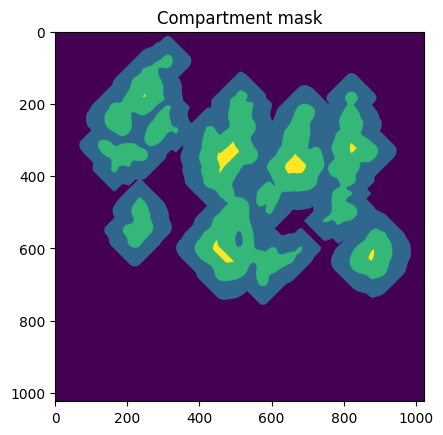

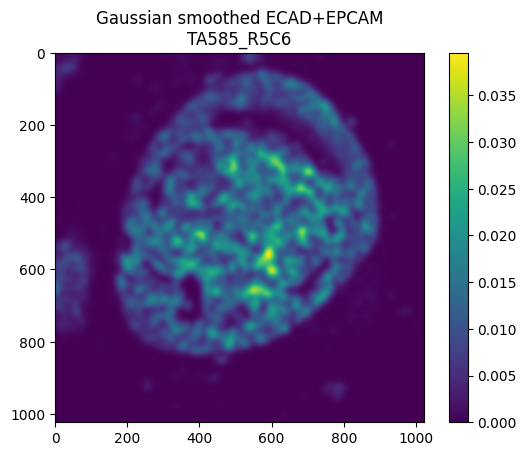

(1024, 1024)


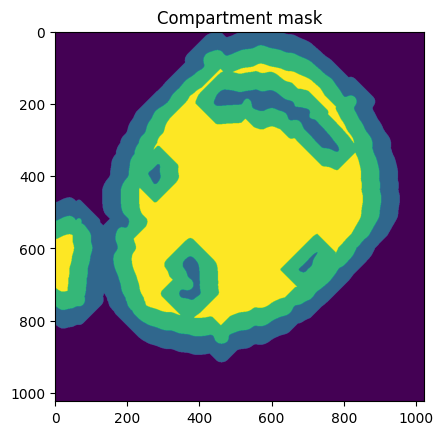

In [9]:
# loop over each FOV and generate the appropriate masks
for folder in folders[:20]:
    ecad = io.imread(os.path.join(channel_dir, folder, 'Ecadherin.tiff'))
    epcam = io.imread(os.path.join(channel_dir, folder, 'EpCAM.tiff'))
    ecad_epcam = ecad + epcam

    # apply Gaussian blur
    img_smoothed = gaussian_filter(ecad_epcam, sigma=10)
    implot = plt.imshow(img_smoothed)
    plt.title(f'Gaussian smoothed ECAD+EPCAM\n{folder}')
    plt.colorbar()
    plt.show()

    # generate cancer/stroma mask by combining segmentation mask with ECAD channel
    seg_label = io.imread(os.path.join(seg_dir, folder + '_whole_cell.tiff'))[0]
    seg_mask = utils.create_cell_mask(seg_label, cell_table_clusters, folder, 'cell_type', ['Cancer'])
    print(seg_mask.shape)

    cancer_mask = utils.create_cancer_boundary(ecad_epcam, seg_mask, min_mask_size=5000, max_hole_size=500, border_size=50, channel_thresh = 0.002)
    cancer_mask = cancer_mask.astype(np.uint8)
    implot = plt.imshow(cancer_mask)
    plt.title('Compartment mask')
    plt.show()

In [12]:
# loop over each FOV and generate the appropriate masks
ns_folders = ns.natsorted(folders)
for folder in ns_folders:
    ecad = io.imread(os.path.join(channel_dir, folder, 'Ecadherin.tiff'))
    epcam = io.imread(os.path.join(channel_dir, folder, 'EpCAM.tiff'))
    ecad_epcam = ecad + epcam

    intermediate_folder = os.path.join(intermediate_dir, folder)
    if not os.path.exists(intermediate_folder):
        os.mkdir(intermediate_folder)

    # generate cancer/stroma mask by combining segmentation mask with ECAD channel
    seg_label = io.imread(os.path.join(seg_dir, folder + '_whole_cell.tiff'))[0]
    seg_mask = utils.create_cell_mask(seg_label, cell_table_clusters, folder, 'cell_type', ['Cancer'])
    cancer_mask = utils.create_cancer_boundary(ecad_epcam, seg_mask, min_mask_size=5000, max_hole_size=500, border_size=50, channel_thresh = 0.002)
    
    cancer_mask = cancer_mask.astype(np.uint8)
    io.imsave(os.path.join(intermediate_folder, 'cancer_mask.png'), cancer_mask,
              check_contrast=False)

    # create mask for slide background
    gold = io.imread(os.path.join(channel_dir, folder, 'Au.tiff'))

    gold_mask = utils.create_channel_mask(img=gold, sigma=2, intensity_thresh=350,
                                          min_mask_size=5000, max_hole_size=1000)

    # erode edges of gold mask so that it doesn't encroach on other masks
    for _ in range(15):
        gold_mask = morphology.binary_erosion(gold_mask)

    # any cell can't be in the gold mask
    gold_mask[seg_label > 0] = 0
    io.imsave(os.path.join(intermediate_folder, 'gold_mask.png'), gold_mask.astype(np.uint8),
                check_contrast=False)

In [13]:
# # create directories to hold masks
individual_dir = os.path.join(mask_dir, 'individual_masks') #individual_masks #'individual_masks-no_tagg_tls'
intermediate_dir = os.path.join(mask_dir, 'intermediate_masks')

if not os.path.exists(individual_dir):
    os.mkdir(individual_dir)

# remove any overlapping pixels from different masks, then save individually
for folder in ns_folders:
    print(folder)
    # read in generated masks  
    intermediate_folder = os.path.join(intermediate_dir, folder)
    cancer_mask = io.imread(os.path.join(intermediate_folder, 'cancer_mask.png'))
    gold_mask = io.imread(os.path.join(intermediate_folder, 'gold_mask.png'))

    cancer_mask[gold_mask == 1] = 0

    # save individual masks
    processed_folder = os.path.join(individual_dir, folder)
    if not os.path.exists(processed_folder):
        os.mkdir(processed_folder)

    for idx, name in zip(range(0, 5), ['empty_slide', 'stroma_core', 'stroma_border',
                                       'cancer_border', 'cancer_core']):
        ### saving
        channel_img = cancer_mask == idx
        io.imsave(os.path.join(processed_folder, name + '.tiff'), channel_img.astype(np.uint8),
                  check_contrast=False)
    
# ### saving
# # compute the area of each mask
assignment_table = utils.assign_cells_to_mask(seg_dir, mask_dir=individual_dir, fovs=ns_folders)

### saving
assignment_table.to_csv(os.path.join(individual_dir, 'cell_annotation_mask.csv'), index=False)

TA507_R3C7
TA507_R4C4
TA508_R4C4
TA585_R1C1
TA585_R1C5
TA585_R2C4
TA585_R2C7
TA585_R3C1
TA585_R3C2
TA585_R3C3
TA585_R3C6
TA585_R4C1
TA585_R4C3
TA585_R4C4
TA585_R5C1
TA585_R5C4
TA585_R5C6
TA585_R5C7
TA585_R6C1
TA585_R6C4
TA585_R6C5
TA585_R6C6
TA585_R7C1
TA585_R7C2
TA585_R7C5
TA585_R7C6
TA585_R7C7
TA585_R8C1
TA585_R8C2
TA585_R8C3
TA585_R8C5
TA585_R9C1
TA585_R9C3
TA585_R9C5
TA585_R9C7
TA585_R11C6
TA585_R11C7
TA585_R12C7
TA586_R1C2
TA586_R3C4
TA586_R4C1
TA586_R4C4
TA586_R5C5
TA586_R6C1
TA586_R6C2
TA586_R6C3
TA586_R7C3
TA586_R8C2
TA586_R8C3
TA586_R8C4
TA586_R8C5
TA586_R9C2
TA586_R9C3
TA586_R10C1
TA586_R10C3
TA586_R11C1
TA586_R11C4
extracting data from TA507_R3C7
extracting data from TA507_R4C4
extracting data from TA508_R4C4
extracting data from TA585_R11C6
extracting data from TA585_R11C7
extracting data from TA585_R12C7
extracting data from TA585_R1C1
extracting data from TA585_R1C5
extracting data from TA585_R2C4
extracting data from TA585_R2C7
extracting data from TA585_R3C1
extracting 